Fixed Source MC code

In [1]:
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
import os

import placzek as pcz

from models import globalvariables as GV
from models import geometry_models as geo_m
from models import physic_model as phy_m
from models import material_model as mat_m
from models import statistic_model as stat_m

from controllers import geometry_controller as geo_c
from controllers import physics_controller as phy_c
from controllers import material_controller as mat_c
from controllers import statistic_controller as stat_c

Import data

In [2]:
PL = 1
LT = -1
particle_squeue = []

# Base directory
base_dir = 'cross_sections_Janis'

# Load data directly with os.path.join
Cnat_total = np.loadtxt(os.path.join(base_dir, 'C', 'Cnat_total.csv'), delimiter=';', skiprows=3)
Cnat_scattering = np.loadtxt(os.path.join(base_dir, 'C', 'Cnat_scattering.csv'), delimiter=';', skiprows=3)

Create isotopes

test 0D

In [3]:
carbon = mat_m.isotope(6,12,1.1E23,Cnat_total[:,0],Cnat_total[:,1],Cnat_total[:,1])
source = phy_m.source(1,GV.LL,100,GV.SOURCE_POSITION,1.,'fixed')

Create materials

In [4]:
core_list = [carbon]
core = mat_m.material(core_list)
reflector_list = [carbon]
reflector = mat_m.material(reflector_list)

Tally creation

In [5]:
distribution = [(core,0,GV.LEnd)]
domain = geo_m.domain(distribution,GV.LL,10000,GV.EE,10000,True)
tally = stat_m.tally(GV.LL,200)

Monte Carlo Code

In [6]:
while tally.iter <= GV.Nstories:
    # inizializzo il ciclo
    tally.iter += 1
    # genero le particelle da simulare
    phy_c.generate_population(source,1.,particle_squeue)
    while len(particle_squeue)>0:
        nn = particle_squeue.pop(0)
        while nn.eof > 0:
            # sample della distanza di volo
            nn.position = phy_c.sample_free_flight(nn,domain)
            if geo_c.is_outofbound(nn,'space'):
                nn.eof = 0
            else:
                # faccio il sample
                stat_c.count_interaction(tally,nn,domain)
                # aggiorno i dati della particella dopo l'interazione
                nn.energy = phy_c.sample_energy_stepf(nn,domain)
                nn.direction = geo_m.direction.get_rnd_direction()
                nn.weight = phy_c.new_weight(nn,domain)
                if geo_c.is_outofbound(nn,'energy'):
                    nn.eof = 0
                else:
                    # russian roulette e splitting
                    stat_c.russian_roulette(nn)
                    stat_c.splitting(nn,particle_squeue)
    # aggiorno i dati statistici
    stat_c.wellford(tally)

    if tally.iter % 100 == 0:  # Print every 100 iterations
        print(f"Iteration: {tally.iter}")

# normalizzazione
avg = tally.avg
sigma = tally.RSD
stat_c.normalization(tally)

Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500
Iteration: 600
Iteration: 700
Iteration: 800
Iteration: 900
Iteration: 1000
Iteration: 1100
Iteration: 1200
Iteration: 1300
Iteration: 1400
Iteration: 1500
Iteration: 1600
Iteration: 1700
Iteration: 1800
Iteration: 1900
Iteration: 2000
Iteration: 2100
Iteration: 2200
Iteration: 2300
Iteration: 2400
Iteration: 2500
Iteration: 2600
Iteration: 2700
Iteration: 2800
Iteration: 2900
Iteration: 3000
Iteration: 3100
Iteration: 3200
Iteration: 3300
Iteration: 3400
Iteration: 3500
Iteration: 3600
Iteration: 3700
Iteration: 3800
Iteration: 3900
Iteration: 4000
Iteration: 4100
Iteration: 4200
Iteration: 4300
Iteration: 4400
Iteration: 4500
Iteration: 4600
Iteration: 4700
Iteration: 4800
Iteration: 4900
Iteration: 5000
Iteration: 5100
Iteration: 5200
Iteration: 5300
Iteration: 5400
Iteration: 5500
Iteration: 5600
Iteration: 5700
Iteration: 5800
Iteration: 5900
Iteration: 6000
Iteration: 6100
Iteration: 6200
Iteration: 6300
I

plots 0D

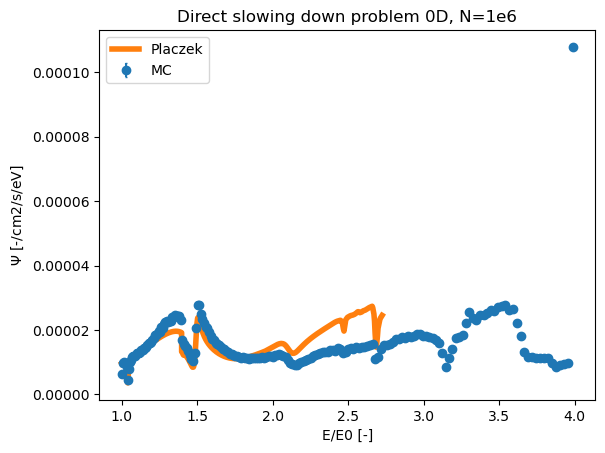

In [7]:
avg = avg.ravel()
sigma = sigma.ravel()

if LT > 0:
    xx = -np.log(tally.energyref/GV.EREF)
    yy = avg*tally.energyref
    if PL > 0:
        plc = pcz.Lplaczek(12)
else:
    xx = tally.energyref/GV.EREF
    yy = avg
    if PL > 0:
        plc = pcz.adj_placzek(12,domain.materials[0].macro_xs_scattering)
        plc[0] *= 1/GV.EREF

plt.errorbar(xx, yy, yerr=sigma*yy, fmt='o',label='MC' ,capsize=1)
if PL > 0:
    plt.plot(plc[0],plc[1],linewidth='4' ,label='Placzek')
if LT > 0:
    plt.xlabel('Letargy [-]')
    plt.ylabel('$\Sigma*\Phi$ [-/cm3/s]')
else:
    plt.xlabel('E/E0 [-]')
    plt.ylabel(r'$\Psi$ [-/cm2/s/eV]')
plt.title('Direct slowing down problem 0D, N=1e6')
#plt.xlim(left=1)
#plt.xscale('log')
plt.legend()
plt.show()

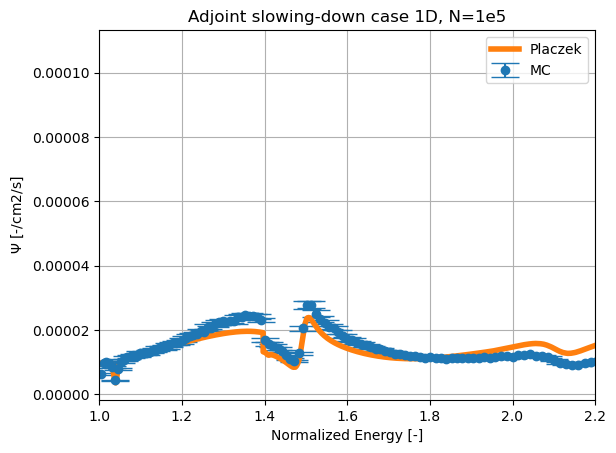

In [9]:
plt.errorbar(xx, yy, yerr=2*yy*sigma, fmt='o', capsize=10, label='MC')
plt.plot(plc[0],plc[1],linewidth='4' ,label='Placzek')
plt.xlabel('Normalized Energy [-]')
plt.ylabel('$\Psi$ [-/cm2/s]')
plt.title('Adjoint slowing-down case 1D, N=1e5')
plt.xlim(1,2.2)
#plt.ylim(top=10)
plt.grid()
plt.legend()
plt.show()